In [1]:
import numpy as np 
import scipy
from scipy.stats import *
from sklearn.gaussian_process.kernels import RBF
import seaborn as sns 
import matplotlib.pyplot as plt 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

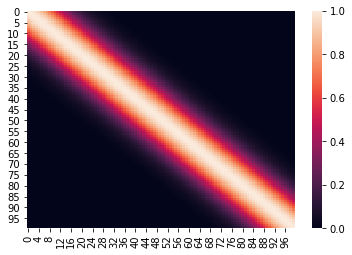

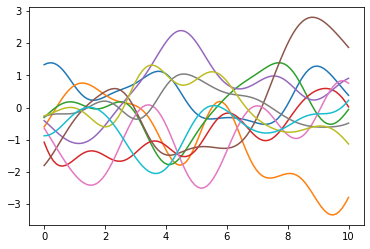

In [2]:
x = np.linspace(0,10,100)

#change this to see effects of length scale on output 
kern = RBF(1.)

cov  = kern.__call__(x.reshape(-1,1),x.reshape(-1,1))

sns.heatmap(cov)
plt.show()


#draw some realization  from the Gaussian process
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)

for i in range(len(y)):
    sns.lineplot(x,y[i,:])
plt.show()

In [3]:
def rbf(x1,x2,ls=1):
    #x1,x2: 2 vector
    return np.exp(-(x1-x2)**2 / ls)
def kern(ls):
    return partial(rbf,ls=ls)

<AxesSubplot:>

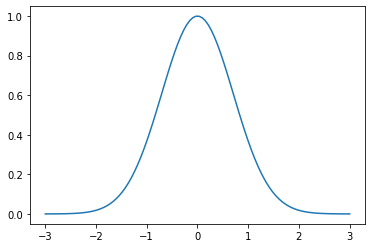

In [4]:
x = np.linspace(-3,3,100)

sns.lineplot(x,[rbf(0,i) for i in x])

In [5]:
x = np.linspace(0,10,100)

In [6]:
def _rbf(x1,x2,ls=1):
    return np.exp(-(x1-x2)**2 / ls)

def _kern(ls):
    return partial(_rbf,ls=ls)

def rbf(x1,x2,ls=1):
#     #return covariance matrix
#     cov = np.zeros((len(x1),len(x2)))
#     k = _kern(ls)
#     for i in range(len(x1)):
#         for j in range(len(x2)):
#             cov[i ,j] = k(x1[i],x2[j])
#     return cov
#    pairwise distance instead of doing 2 for loops
    dist = scipy.spatial.distance.cdist(x1.reshape(-1,1),x2.reshape(-1,1))
    return np.exp(- dist**2 / ls)
        

def kern(ls):
    return partial(rbf,ls=ls)
    

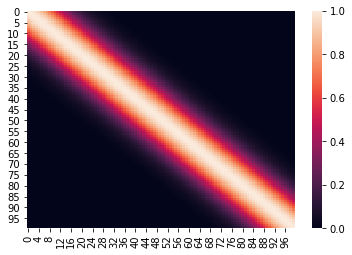

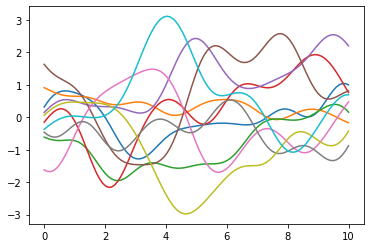

In [7]:
cov = rbf(x,x,ls=2)
sns.heatmap(cov)
plt.show()


#draw some realization  from the Gaussian process
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)

for i in range(len(y)):
    sns.lineplot(x,y[i,:])
plt.show()

# Now, let's see what's inside

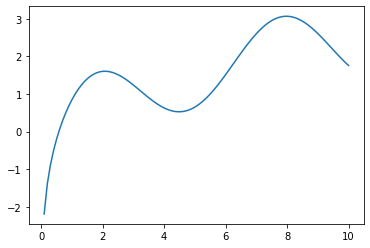

In [8]:
from functools import partial
x = np.linspace(0,10,100)
f = lambda x: np.log(x) + np.sin(x)
sns.lineplot(x,f(x));

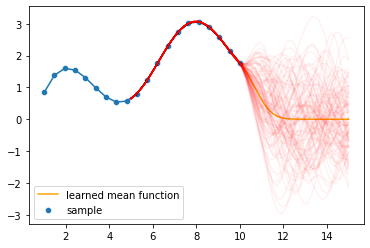

In [9]:
x1 = np.linspace(1,10,20)
x2 = np.linspace(5,15,50)
ls = 1

# Rasumussen & Williams, Gaussian processes for machine learning , chapter 2, eq 2.19
# note that there is a better way to do this as indicated by the alg at the end of the chapter 
# which use a linear solver, instead of inverting this matrix, which is more stable. This is done 
# for demonstration purpose
y2 = rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)) @ f(x1)
covy2 = rbf(x2,x2,ls) - rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1,ls)) @ rbf(x1,x2,ls)


sns.scatterplot(x1,f(x1),label='sample')
sns.lineplot(x1,f(x1))

sns.lineplot(x2,y2,label='learned mean function',color='orange')
realization = np.random.multivariate_normal(mean=y2, cov=covy2, size=100)
for i in range(100):
    sns.lineplot(x2,realization[i,:],color='red',alpha=0.05)





y2 is a linear combination of f(x1)
-> GP is a linear smoother with a specific weights, the smoothing coefficent is K(x2,x1) * inverse( K(x1,x1) ). 


The inverse of the covairiance matrix is called precision matrix, which means how correlated those points are. Basically, the smoothing coeff is a product of how far it is from the observed data ( how much influence we have from observed data) and how relatively correlate the observed data is. If it's all move together ( high precision, low covariance), then the new point would probably move along with it. If it's far from all the move it move it points, it'll move it less.

the covariance of y, as you can see, does not depend on the value of f(x1). This is purely the result 
of the kernel that we choose.

Conceptually, we're removing all the lines that does not pass thru the sample points, and calculate the covariance of the remainning process.

Let's see inside 

<AxesSubplot:>

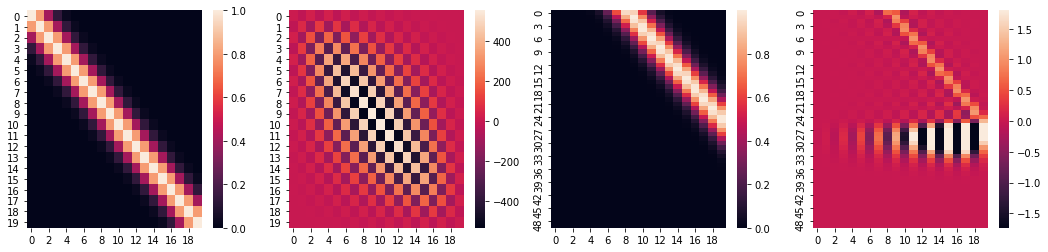

In [10]:


plt.figure(figsize=(18,4))

# covariance of observed data
plt.subplot(1,4,1)
sns.heatmap(rbf(x1,x1))

# precision of observed data
plt.subplot(1,4,2)
sns.heatmap(np.linalg.inv(rbf(x1,x1)))

#covariance of new data with respect to observed
# (how varied the new data should be )
plt.subplot(1,4,3)
sns.heatmap(rbf(x2,x1,ls))

#estimation of the new data
plt.subplot(1,4,4)
sns.heatmap(rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)


bisecting the 4th matrix into 2 component

<AxesSubplot:>

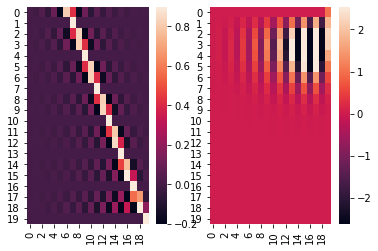

In [11]:
# the part that varies with observed
plt.subplot(1,2,1)
x3 = np.linspace(4,10,20)
sns.heatmap(rbf(x3,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)

#the part that's confused and don't know to to move it move it
plt.subplot(1,2,2)
x3 = np.linspace(10,15,20)
sns.heatmap(rbf(x3,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)



In linear smoother literature,(see bottom for example) we find a set of weights to combine y_i to give a prediction of a new location y*. The product K(x2,x1) * inverse( K(x1,x1)  is called an *equivalent kernel* for a linear smoother. 

the checker pattern on the precision matrix is result of the  inversion of the covariance matrix. It give raise to the oscilating/ripple pattern of Equivalent Kernel that we see in chapter 2 of the book.

see more https://homepages.inf.ed.ac.uk/ckiw/postscript/solwilfinal.pdf

In [12]:
x = np.array([10,11,12])
np.linalg.inv(rbf(x,x))

array([[ 1.17809521, -0.49205091,  0.15943785],
       [-0.49205091,  1.36203083, -0.49205091],
       [ 0.15943785, -0.49205091,  1.17809521]])

the function rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)) is called the weight function

# Let put it to some good use 

In [14]:
def gp_predict(x1,y1,x2,kern):
    # predict x2 given a training set x1,y1 and kernel kern
    assert len(x1) == len(y1)
    y2 = kern(x2,x1) @ np.linalg.inv(kern(x1,x1)) @ y1
    covy2 = kern(x2,x2) - kern(x2,x1) @ np.linalg.inv(kern(x1,x1)) @ kern(x1,x2)
    return y2, covy2
#for a single point predict, se eq 2.27 

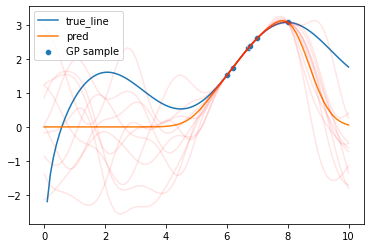

In [15]:
x = np.linspace(0,10,100)

gpx = np.array([6,6.2,6.7,6.77,7,8])
gpy = f(gpx)
k = kern(ls=1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


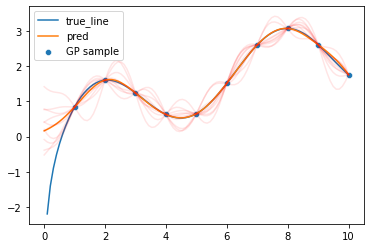

In [16]:
x = np.linspace(0,10,100)

gpx = np.linspace(1,10,10)
gpy = f(gpx)
k = kern(ls=1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


## Bad kernel and how it affects the output

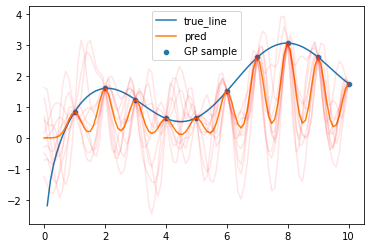

In [17]:
x = np.linspace(0,10,100)

gpx = np.linspace(1,10,10)
gpy = f(gpx)
k = kern(ls=.1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


# Kriging
- find the next best location to explore , given the data points 

In [55]:
import time 
def f(x,cost=0):
    time.sleep(cost)
    return np.log(x) + np.sin(x)



def krig(f,lower,upper,kern,nstep=10,exploration=.9,cost=0,gp_estimator = gp_predict):
    """
        find the maximum of *any* costly function with bayesian optimization
        strategy: evaluate f at some point, and use our assumption of how smooth the 
        function f is, find the next location that hopefully produce better result.
        
        the GP kernel control how smoothe we think the function is
        
        we also do not want to find and stick to a local minima, so exploration is encouraged
    
        params:
            f: the function to maximize
            lower, upper: float, range of our exploration

    """
    x = np.array([np.random.uniform(lower,upper)])
    y = np.array([])
    
    
    for step in range(nstep):
        _y = f(x[-1],cost=cost)
        y = np.concatenate([y,[f(x[-1],cost=cost)] ])
        seq = np.argsort(np.array(x))
    
        y = y[seq]
        x = x[seq]
        
        x2 = np.linspace(lower,upper,100)


        mean,cov  = gp_estimator(x, y, x2, kern)
        y2 = np.random.multivariate_normal(mean=mean, cov=cov, size=len(x2))

        for s in range(10):
            sns.lineplot(x2,y2[s,:],color='red',alpha=0.1)   
        sns.lineplot(x2,f(x2))
        sns.lineplot(x2,mean,color='orange')


        #which bin this point belong to 
        binloc = np.digitize(x2,x)

        agg = {b:[] for b in np.unique(binloc)}
        for i in range(len(y2)):
            for j,loc in enumerate(binloc):
                agg[loc] += y2[i,j],

        #choosing the bin by maximizing potential 
        vuong_dep_zai = partial(np.quantile,q=0.95)

        bin_potential = [(b,vuong_dep_zai(v) ) for b,v in agg.items()]
        best_bin,val = sorted(bin_potential,key=lambda _x:_x[1],reverse=True)[0]
        rand_bin = np.random.choice(list(agg.keys()))

        #exploration vs exploitation
        dest = rand_bin if np.random.uniform() < exploration else best_bin
        _x = [lower] + list(x) + [upper]
        new_location  = (_x[dest] + _x[dest+1]) / 2     
        
        #prevent GP from breaking with singular cov matrix
        if any([np.isclose(new_location,i,0.01) for i in x]): 
            new_location  = (_x[rand_bin] + _x[rand_bin+1]) / 2  
            
        x = np.concatenate([x,[new_location]])


        plt.axvline(new_location,color='green',label='next_location',alpha=0.3)
        plt.show()        




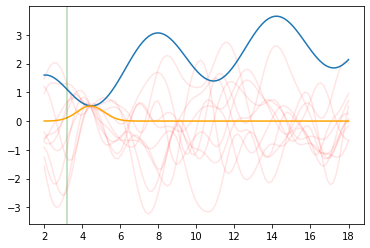

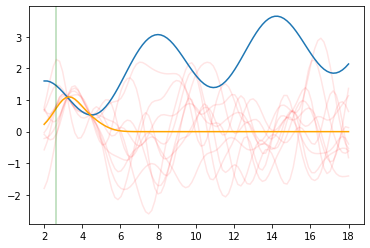

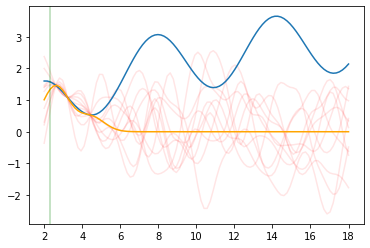

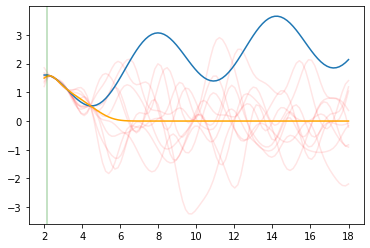

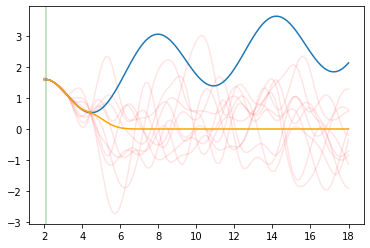

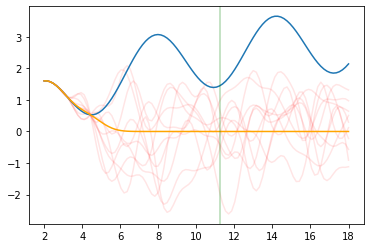

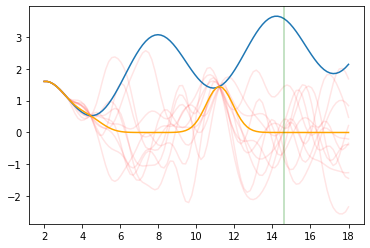

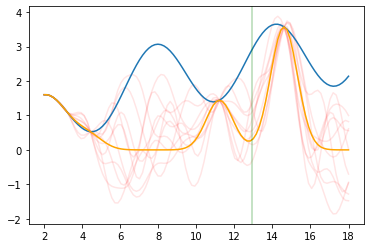

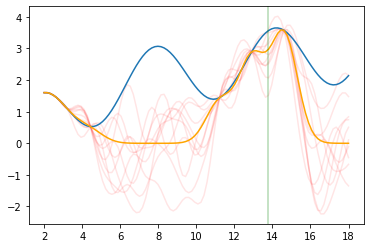

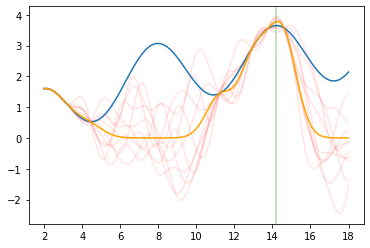

In [59]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=1)
a = krig(f,2,18,k,nstep=10,exploration=0.2,cost=0)

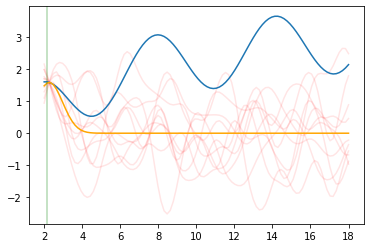

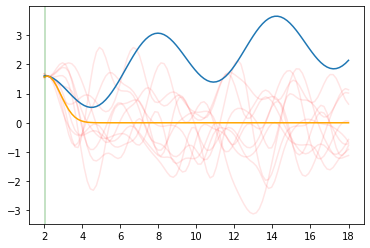

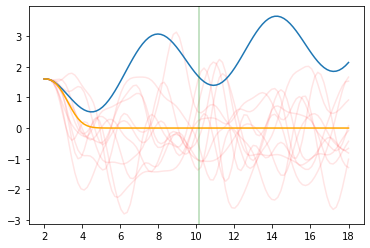

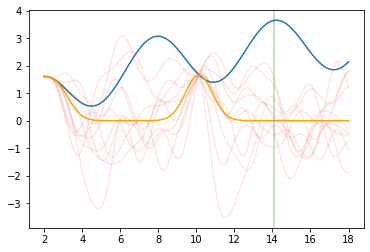

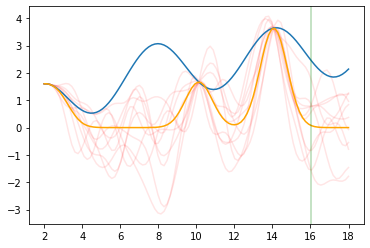

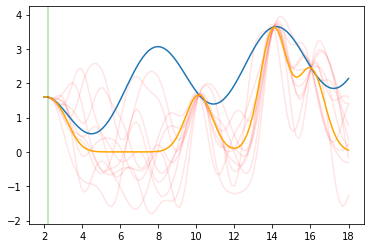

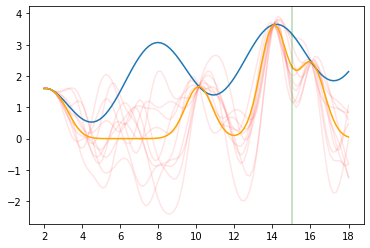

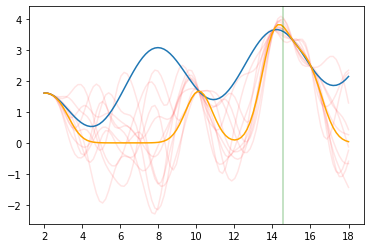

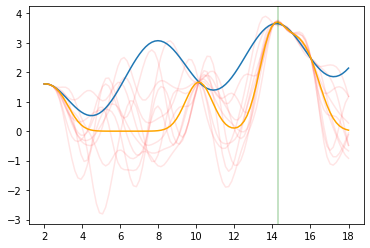

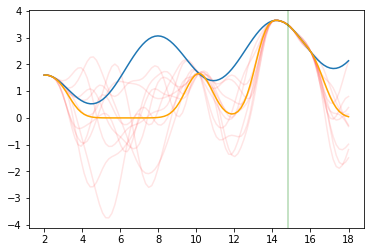

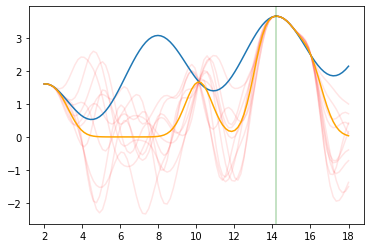

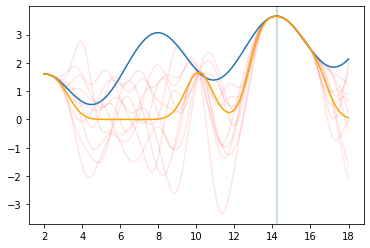

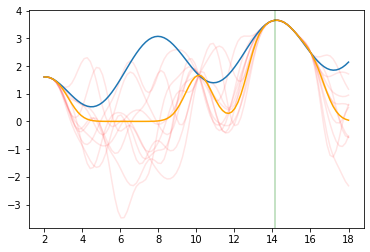

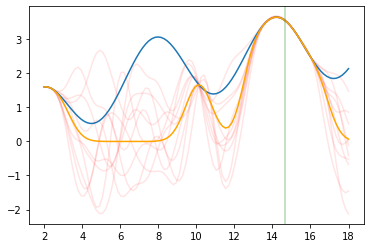

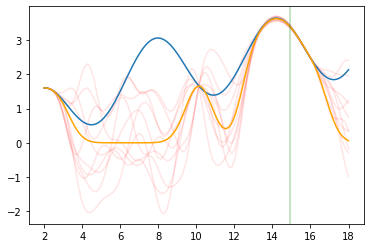

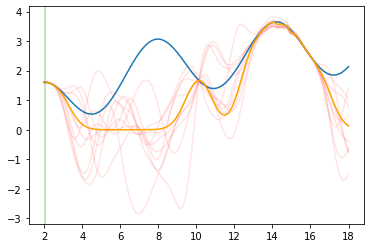

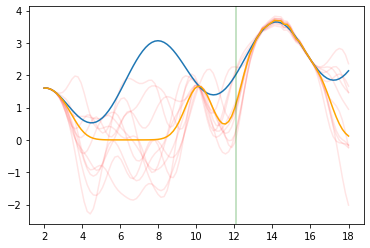

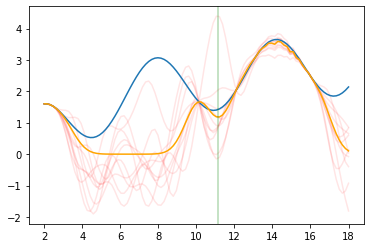

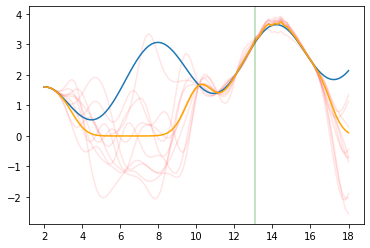

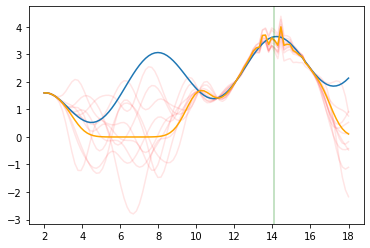

In [20]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=1)
a = krig(f,2,18,k,nstep=20,exploration=0.5,cost=0)

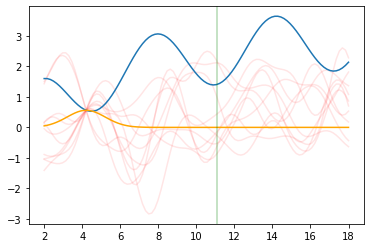

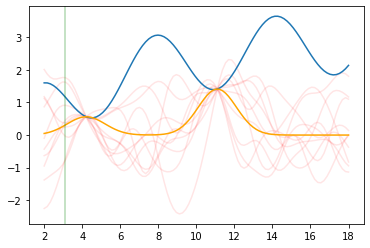

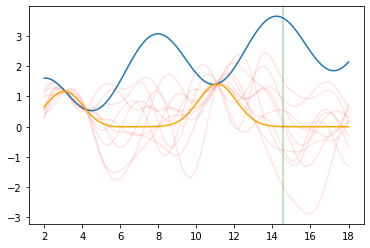

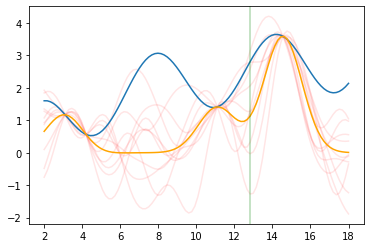

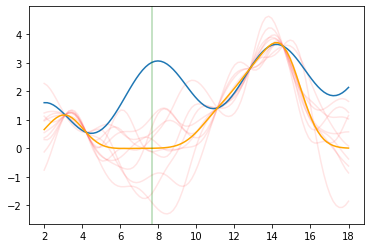

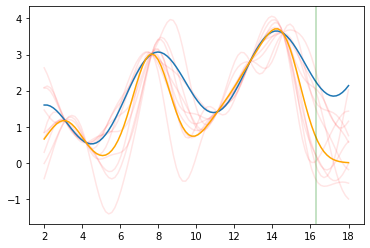

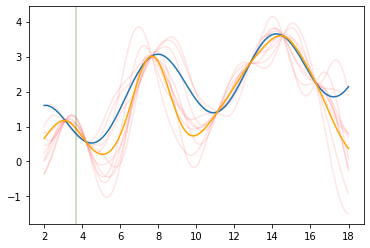

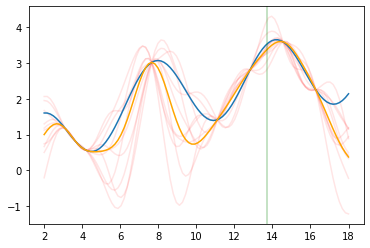

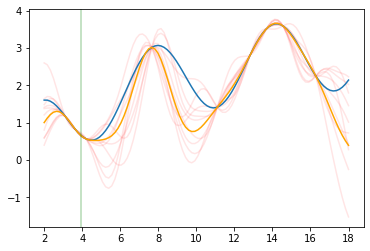

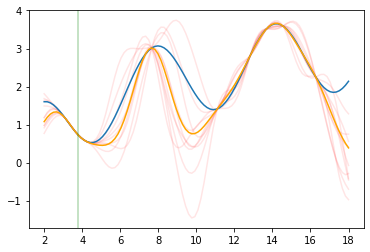

In [62]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=2)
a = krig(f,2,18,k,nstep=10,exploration=0.9,cost=0)

In [22]:
#adding noise to the Kernel estimate to reflect the level of accuracy of our measurement

In [63]:

def gp_noise(x1,y1,x2,kern,noise=0.01):
    assert len(x1) == len(y1)
    #make it more stable for numerical optim
    k11 = kern(x1,x1) + np.random.normal(0,noise**2,size=len(x1)) * np.eye(len(x1))
    
    y2 = kern(x2,x1) @ np.linalg.inv(k11) @ y1
    covy2 = kern(x2,x2) - kern(x2,x1) @ np.linalg.inv(k11) @ kern(x1,x2)
    return y2, covy2


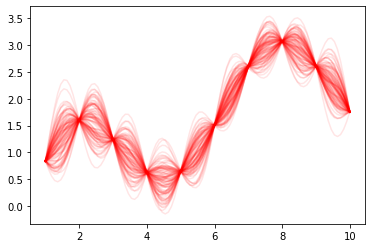

In [64]:
x1 = np.linspace(1,10,10)
x2 = np.linspace(1,10,100)

m,sig  = gp_noise(x1,f(x1),x2,kern(ls=1))

y2 = np.random.multivariate_normal(mean=m, cov=sig, size=100)
for i in range(len(y2)):
    sns.lineplot(x2,y2[i,:],color='red',alpha=0.1)

In [65]:
gpnoise_estimator = partial(gp_noise,noise=0.1)

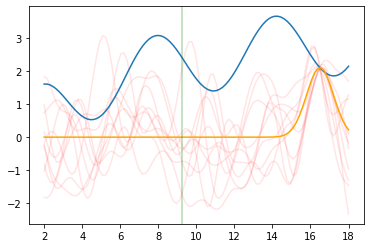

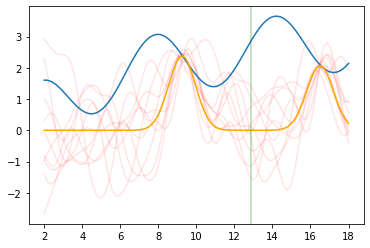

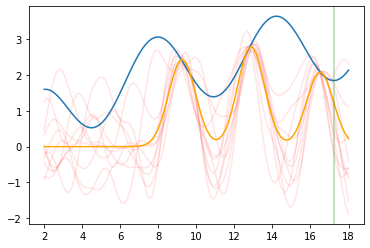

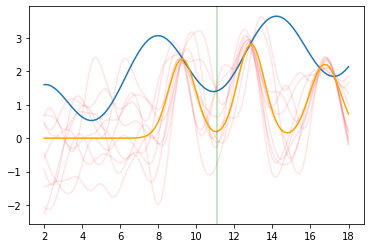

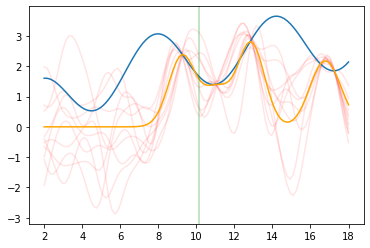

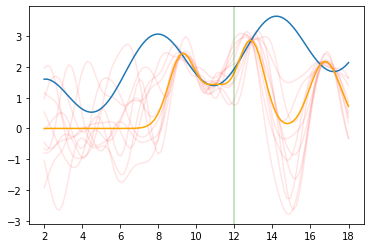

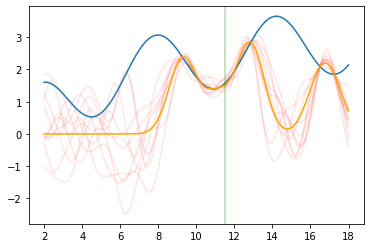

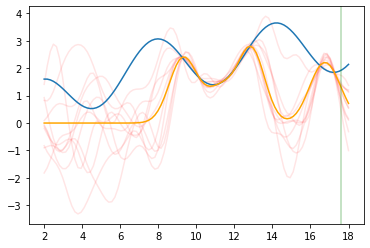

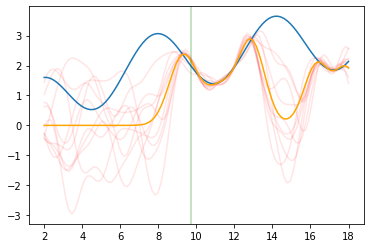

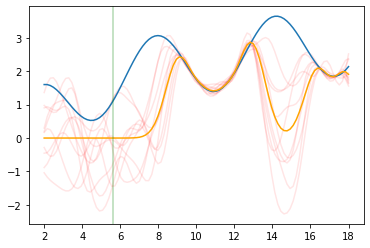

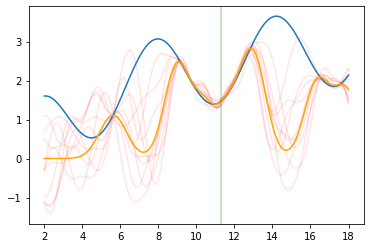

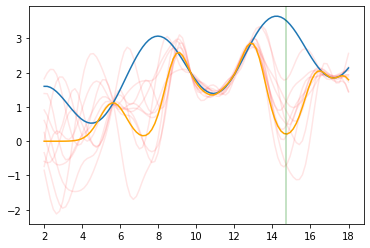

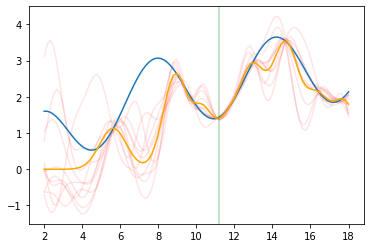

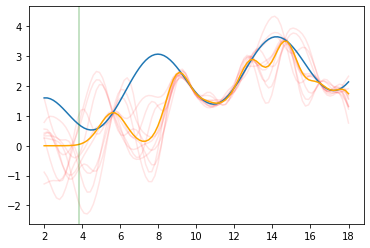

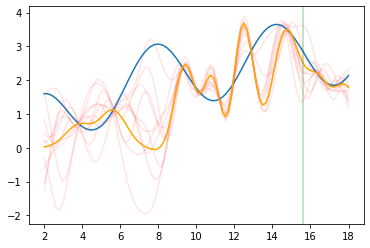

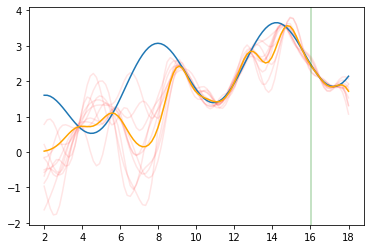

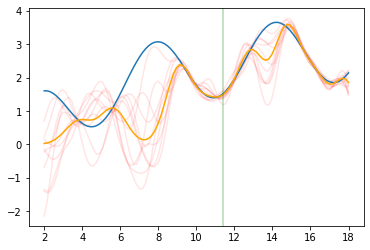

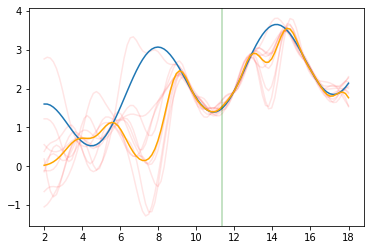

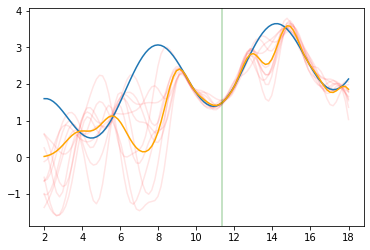

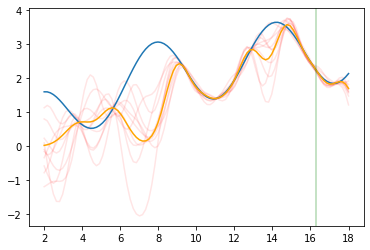

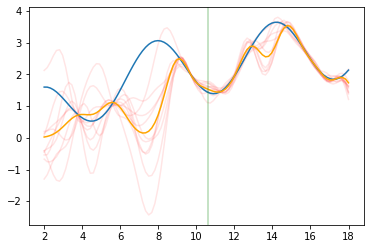

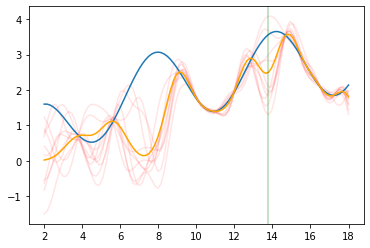

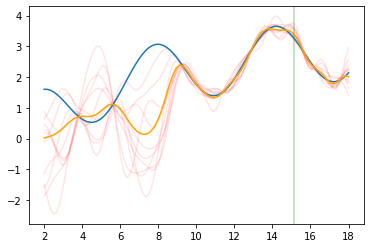

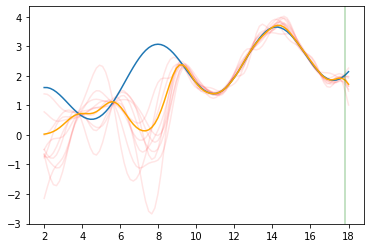

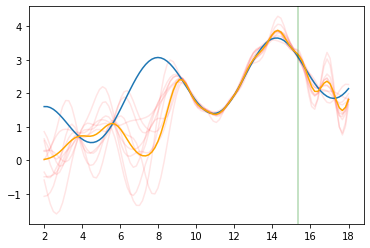

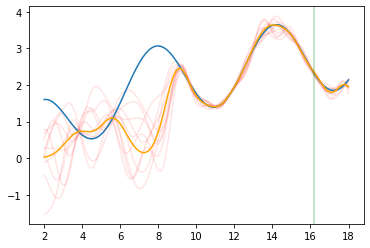

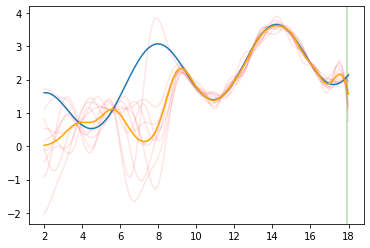

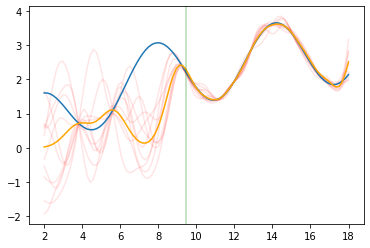

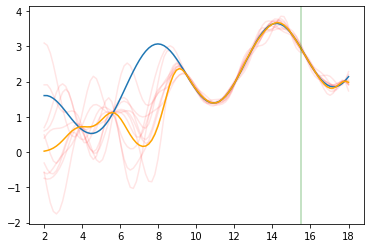

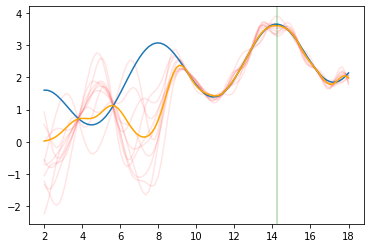

In [66]:
a = krig(f,2,18,kern(ls=1),nstep=30,exploration=0.99,gp_estimator=gpnoise_estimator)

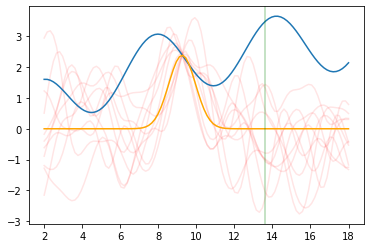

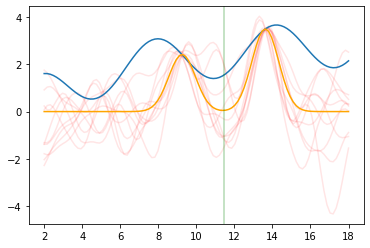

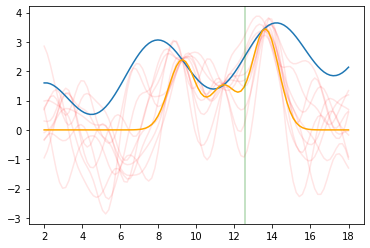

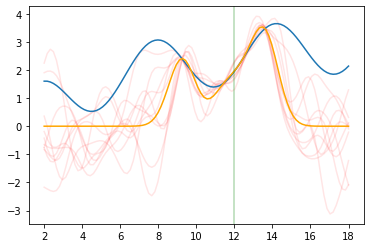

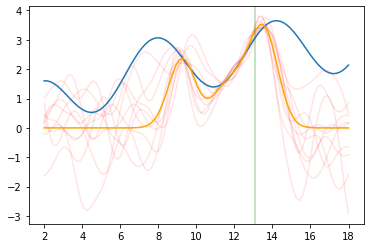

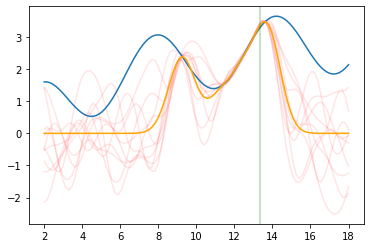

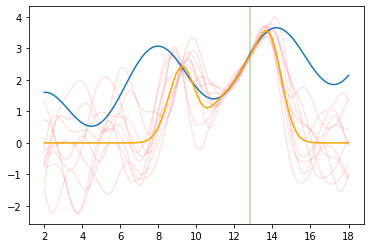

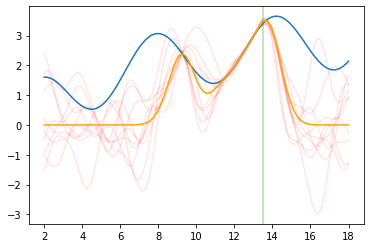

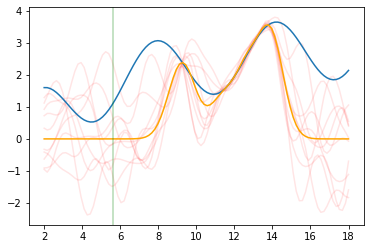

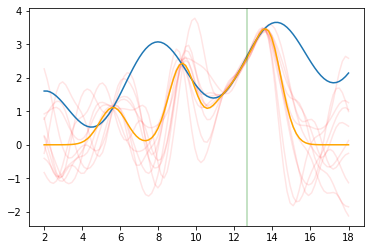

In [67]:
a = krig(f,2,18,kern(ls=1),nstep=10,exploration=0.5,gp_estimator=gpnoise_estimator)

# Linear smoother 

<AxesSubplot:>

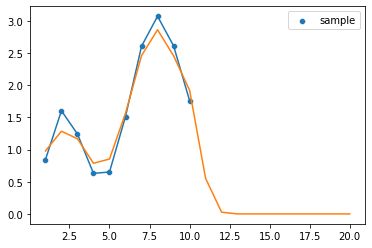

In [28]:
def _rbf(x1,x2,ls=1.):
    return np.exp(-(x1-x2)**2 / ls)

def linear_smoother(x1,y1,x2):
    # Nadaraya-Watson estimator predictor generate prediction for a single point
    
    weights = np.array([_rbf(x2,i) for i in x1])
    weights = weights/weights.sum()
    return np.sum(y1*weights)
def _rbf(x1,x2,ls=1.):
    return np.exp(-(x1-x2)**2 / ls)

def linear_smoother(x1,y1,x2):
    # Nadaraya-Watson estimator predictor generate prediction for a single point
    
    weights = np.array([_rbf(x2,i) for i in x1])
    
    #linear smoother weight 
#     weights = weights/weights.sum()
    
    #GP weight 
    weights = weights * np.linalg.inv(rbf(x1,x1))
        
    return np.sum(y1*weights)
x1 = np.linspace(1,10,10)
x2 = np.linspace(1,20,20)


sns.scatterplot(x1,f(x1),label='sample')
sns.lineplot(x1,f(x1))

pred  = [linear_smoother(x1,f(x1),i) for i in x2]
sns.lineplot(x2,pred)
#see the mean level does not go to zero as with GP, it stuck with the last value it sees

# Some interesting kernels

In [29]:
from sklearn.gaussian_process.kernels import *

## standard kernels 

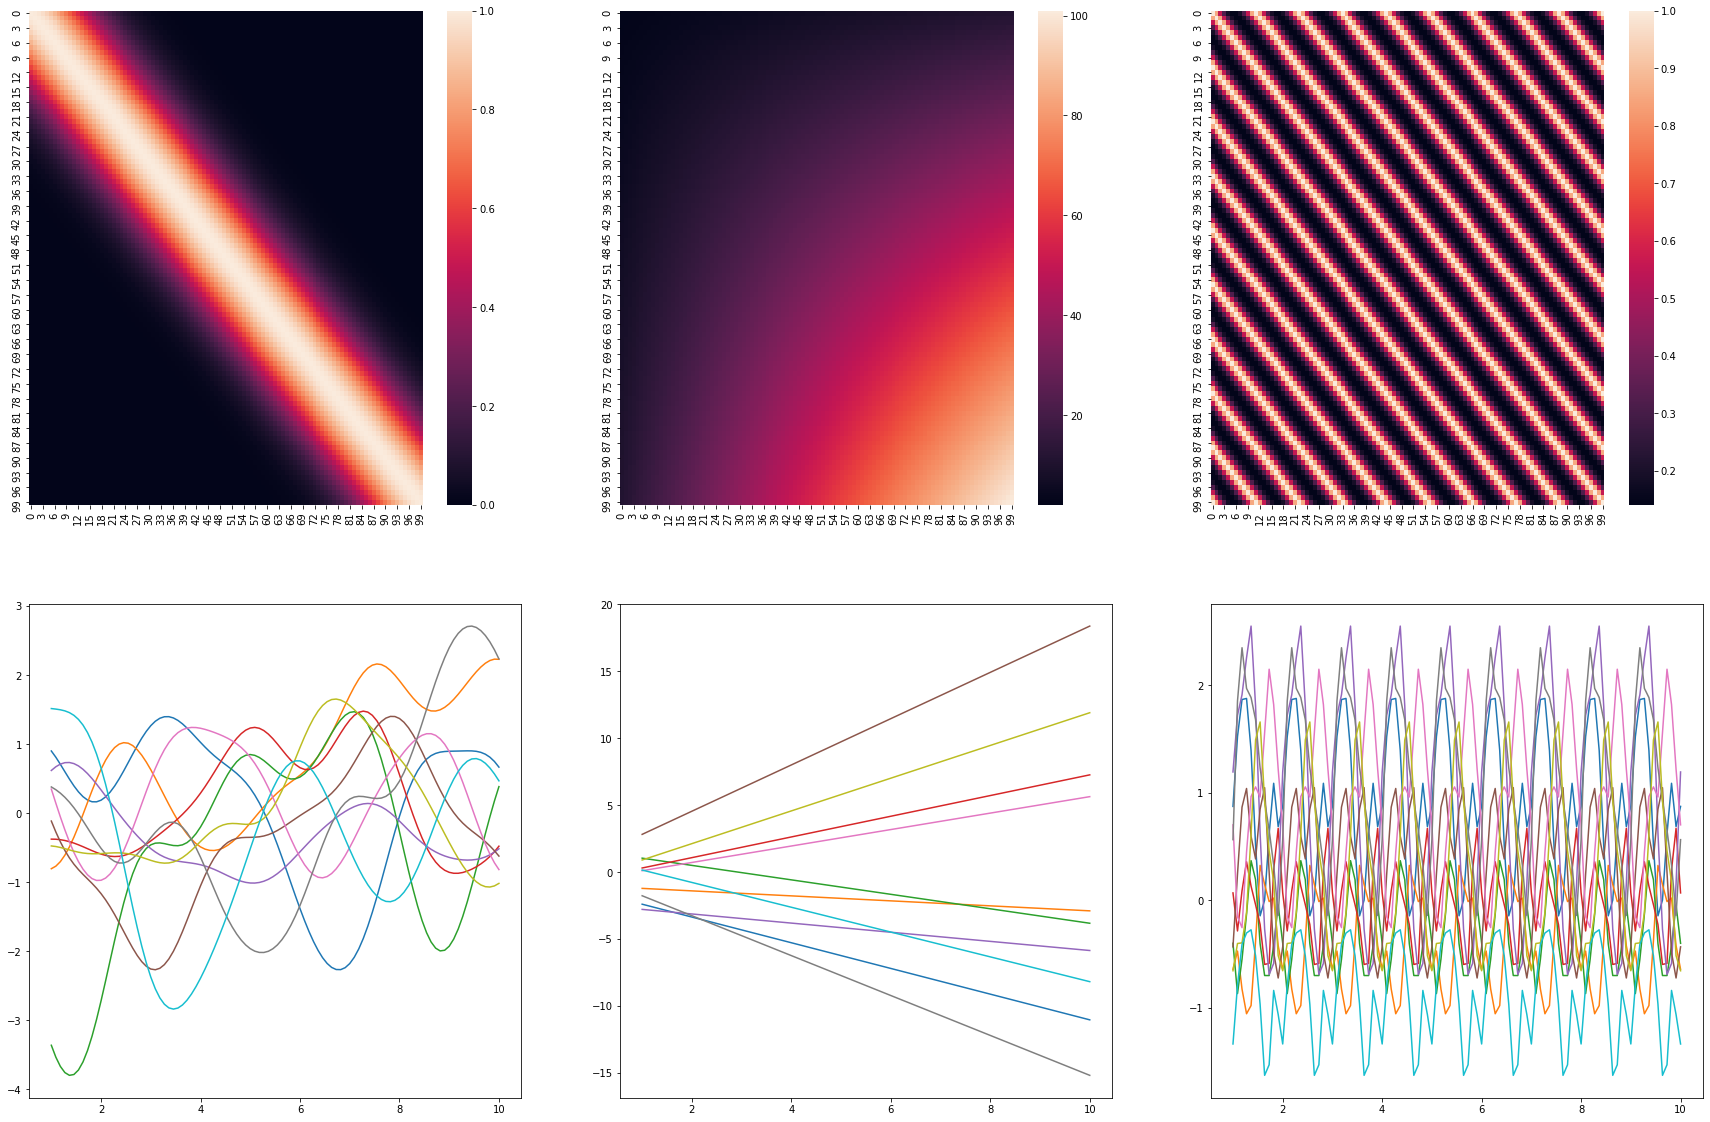

In [30]:
x = np.linspace(1,10,100)

kernels = [RBF(1),DotProduct(1),ExpSineSquared(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


## kernels combinations 

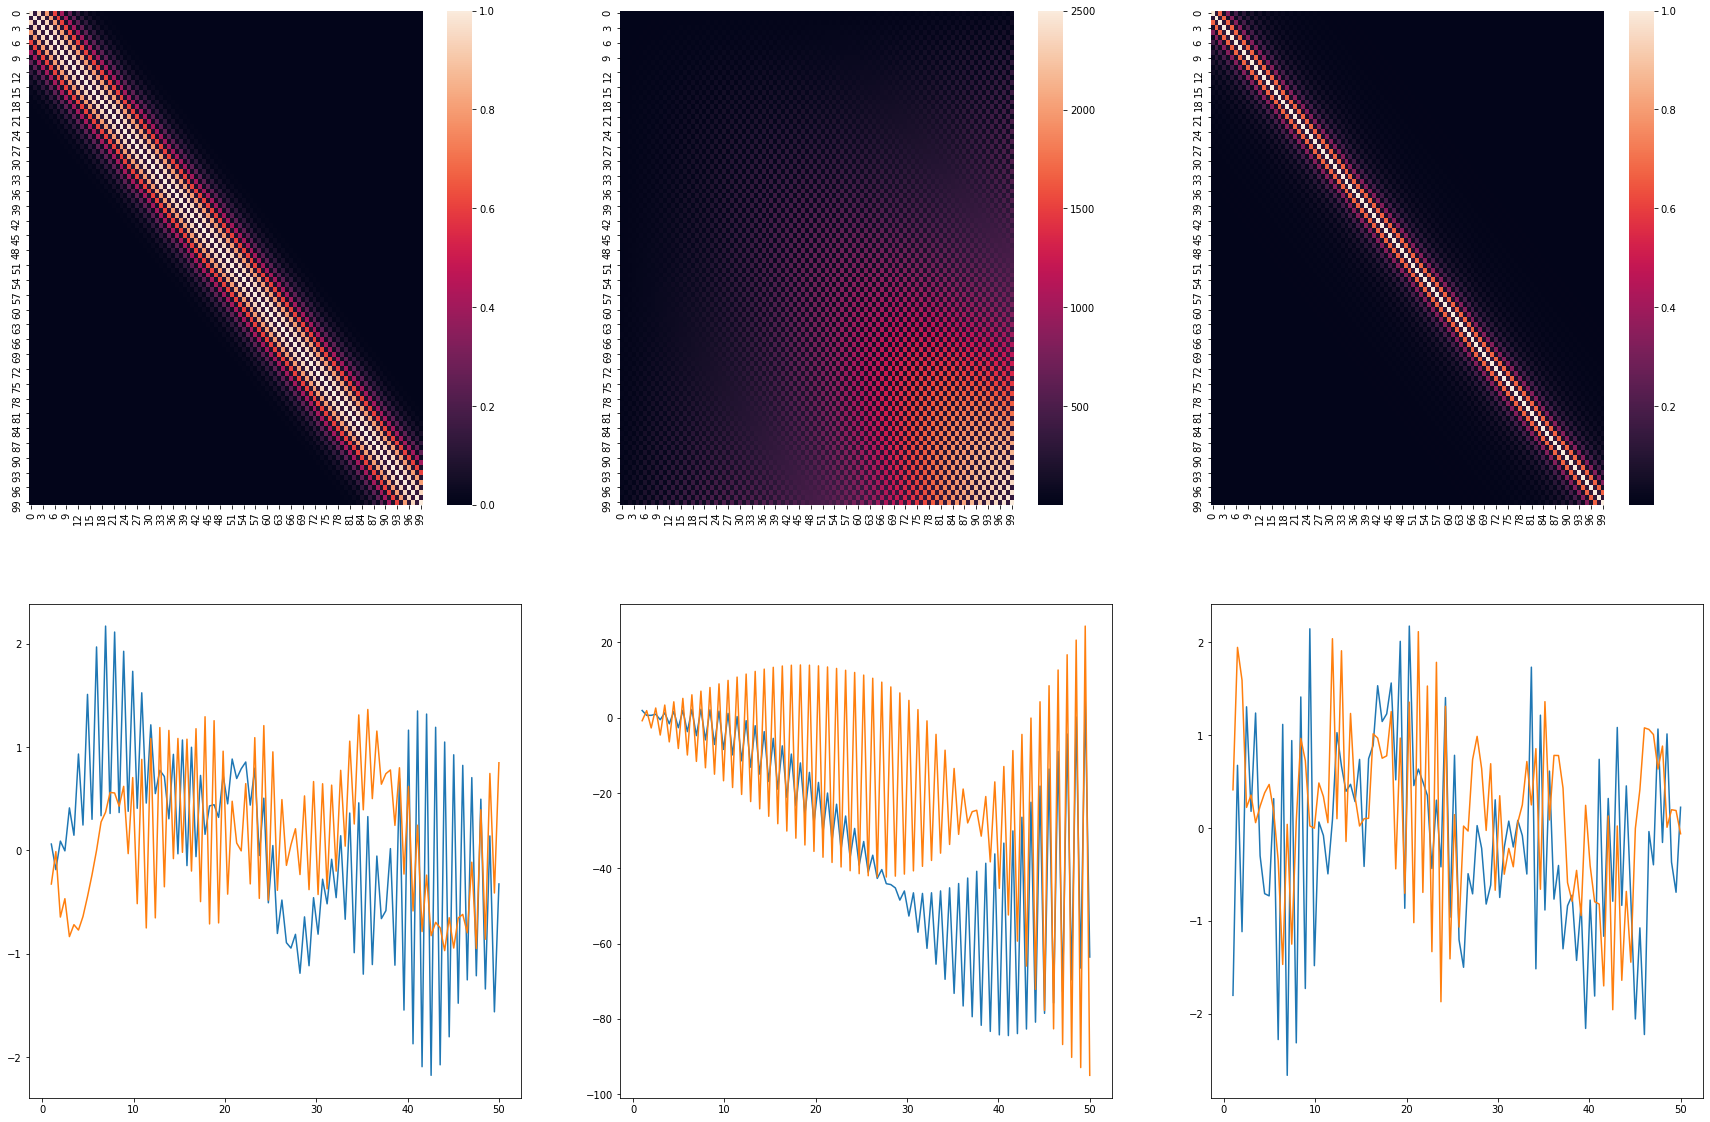

In [31]:
x = np.linspace(1,50,100)

kernels = [ExpSineSquared() * RBF(3), 
           ExpSineSquared() * DotProduct(1),
           ExpSineSquared(1)* RationalQuadratic(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


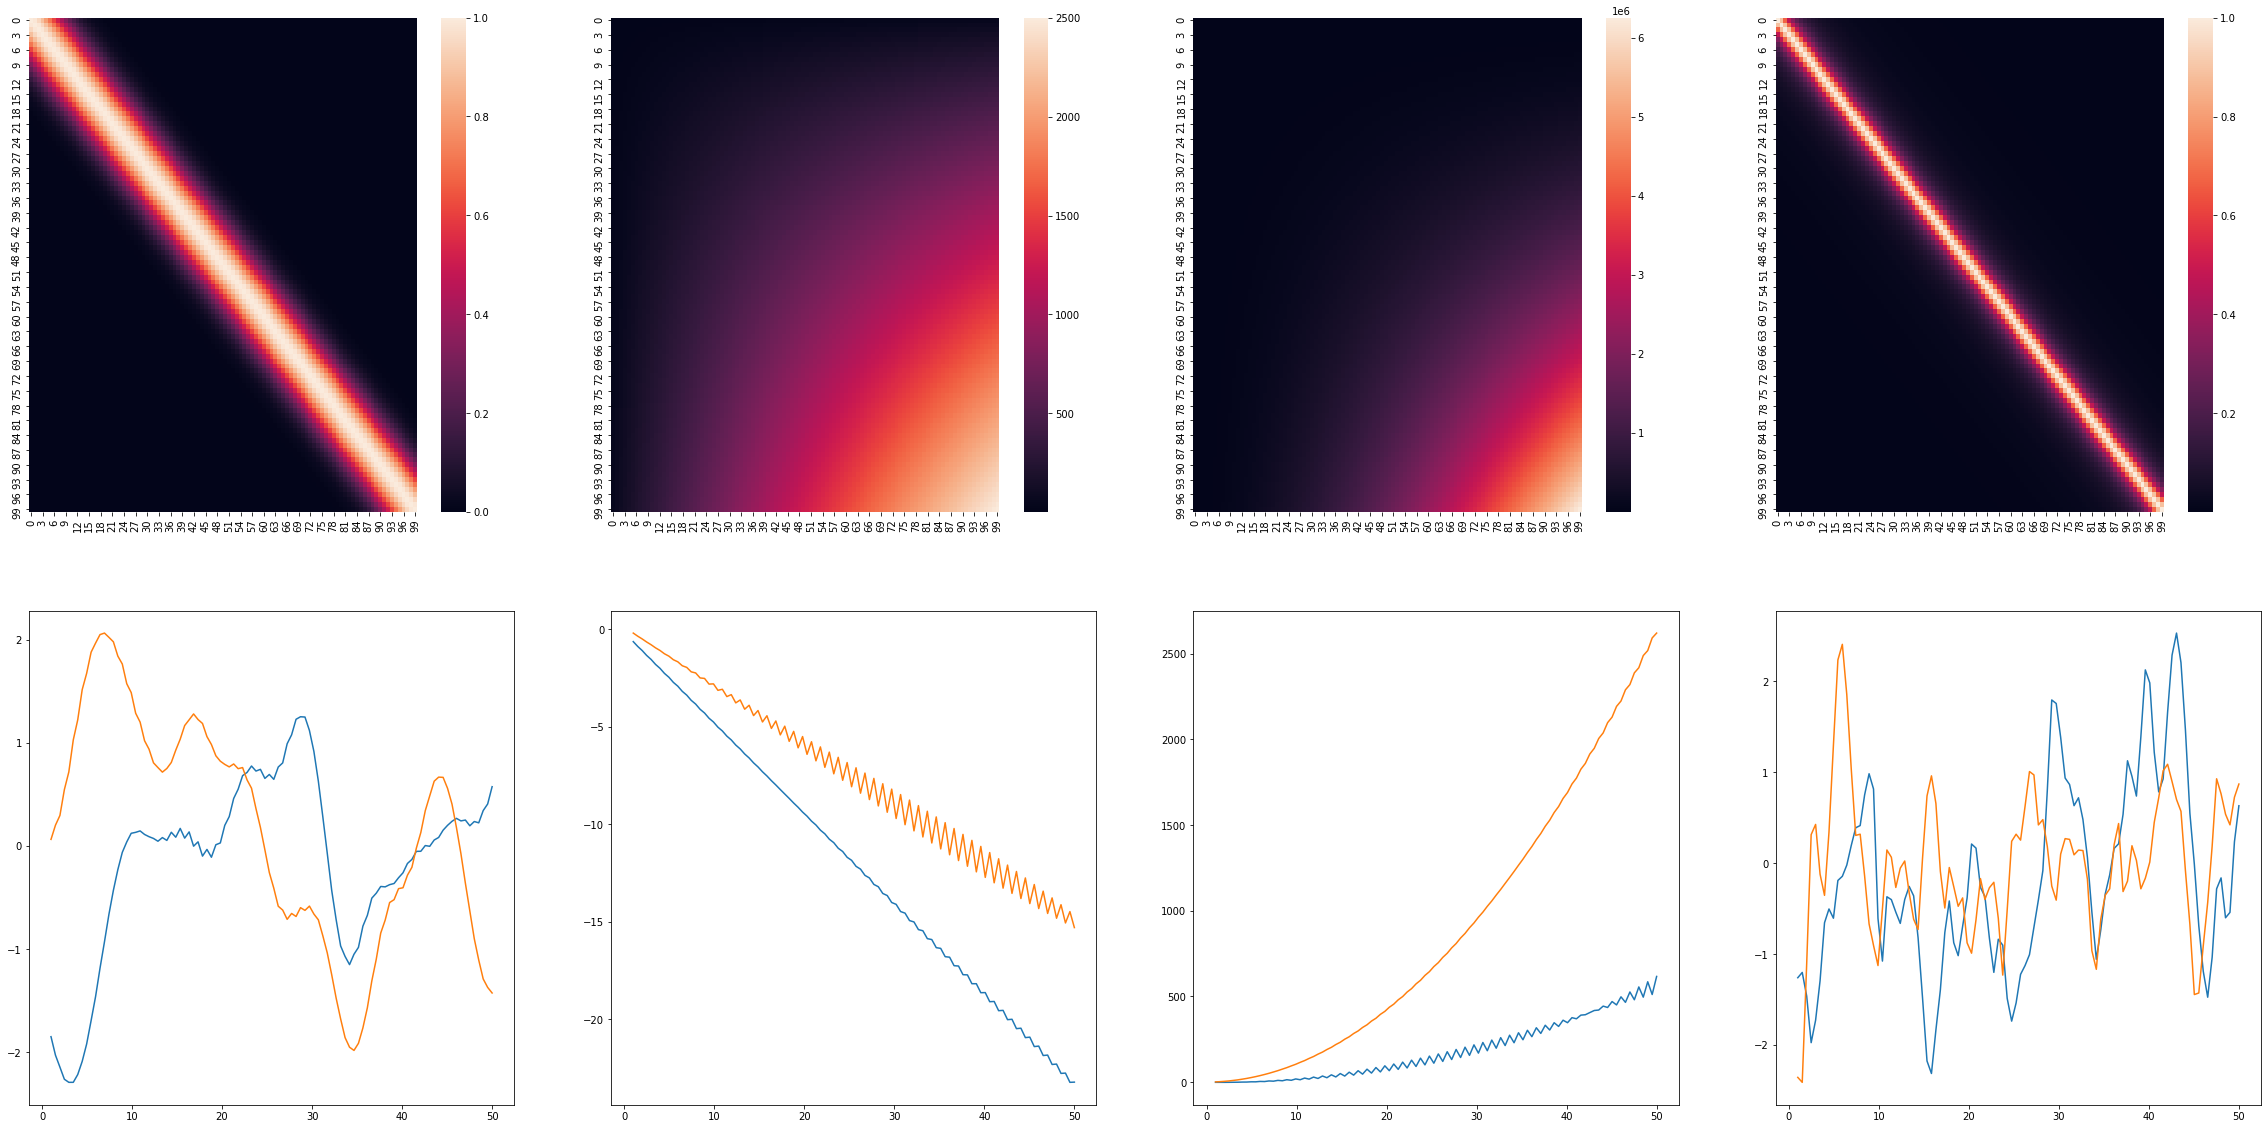

In [32]:
x = np.linspace(1,50,100)

kernels = [ExpSineSquared(50) * RBF(3), 
           ExpSineSquared(50) * DotProduct(1),
           ExpSineSquared(50) * DotProduct()**2,
           ExpSineSquared(50)* RationalQuadratic(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


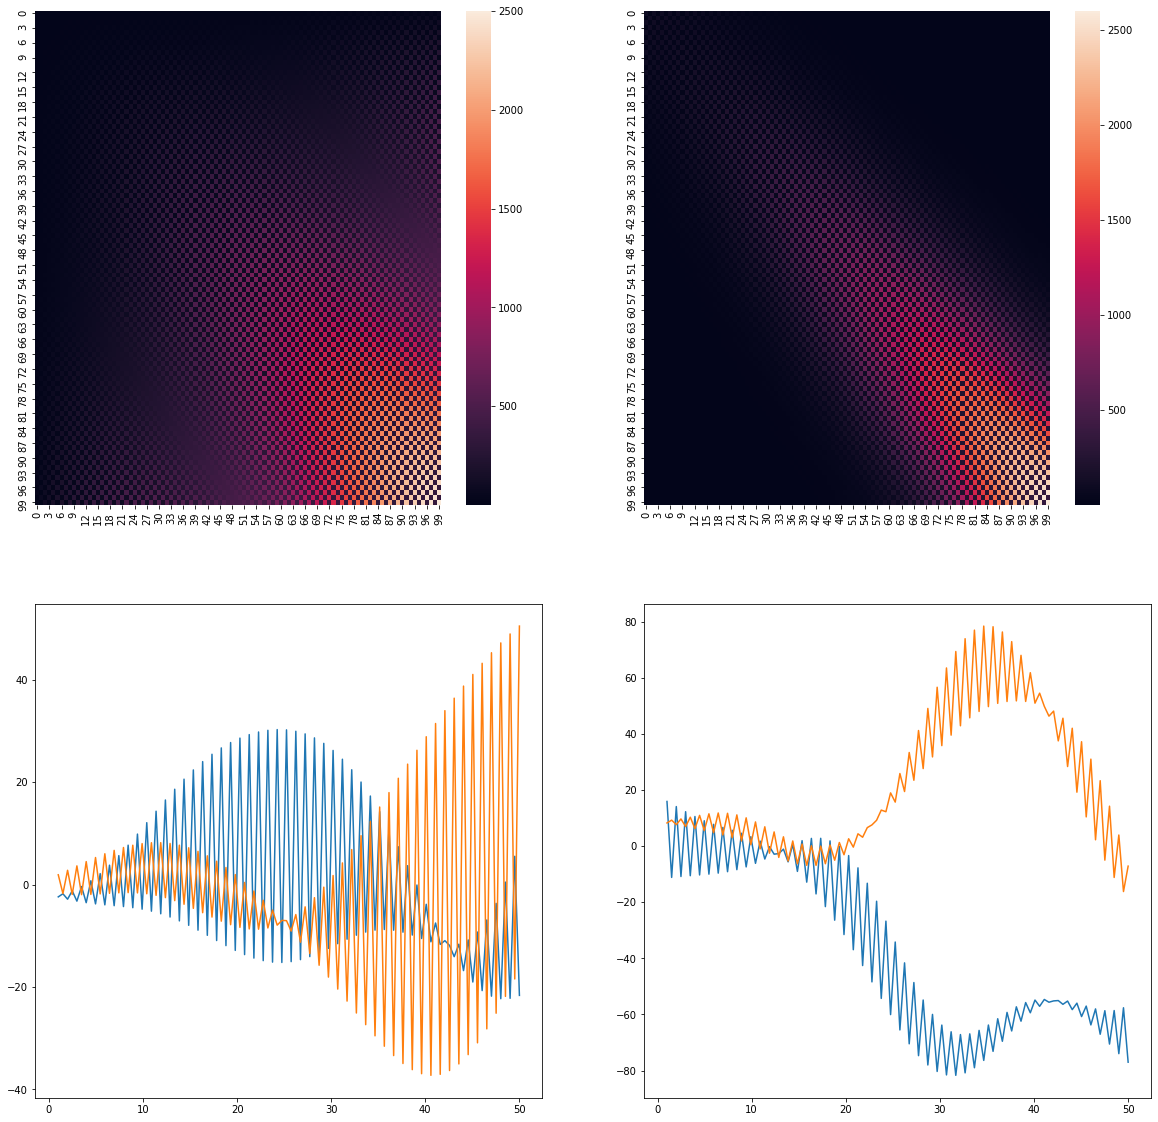

In [33]:
x = np.linspace(1,50,100)

kernels = [
            RBF(10) + DotProduct(1) * ExpSineSquared(),
            RBF(10) * DotProduct(10) * ExpSineSquared() ,
           
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


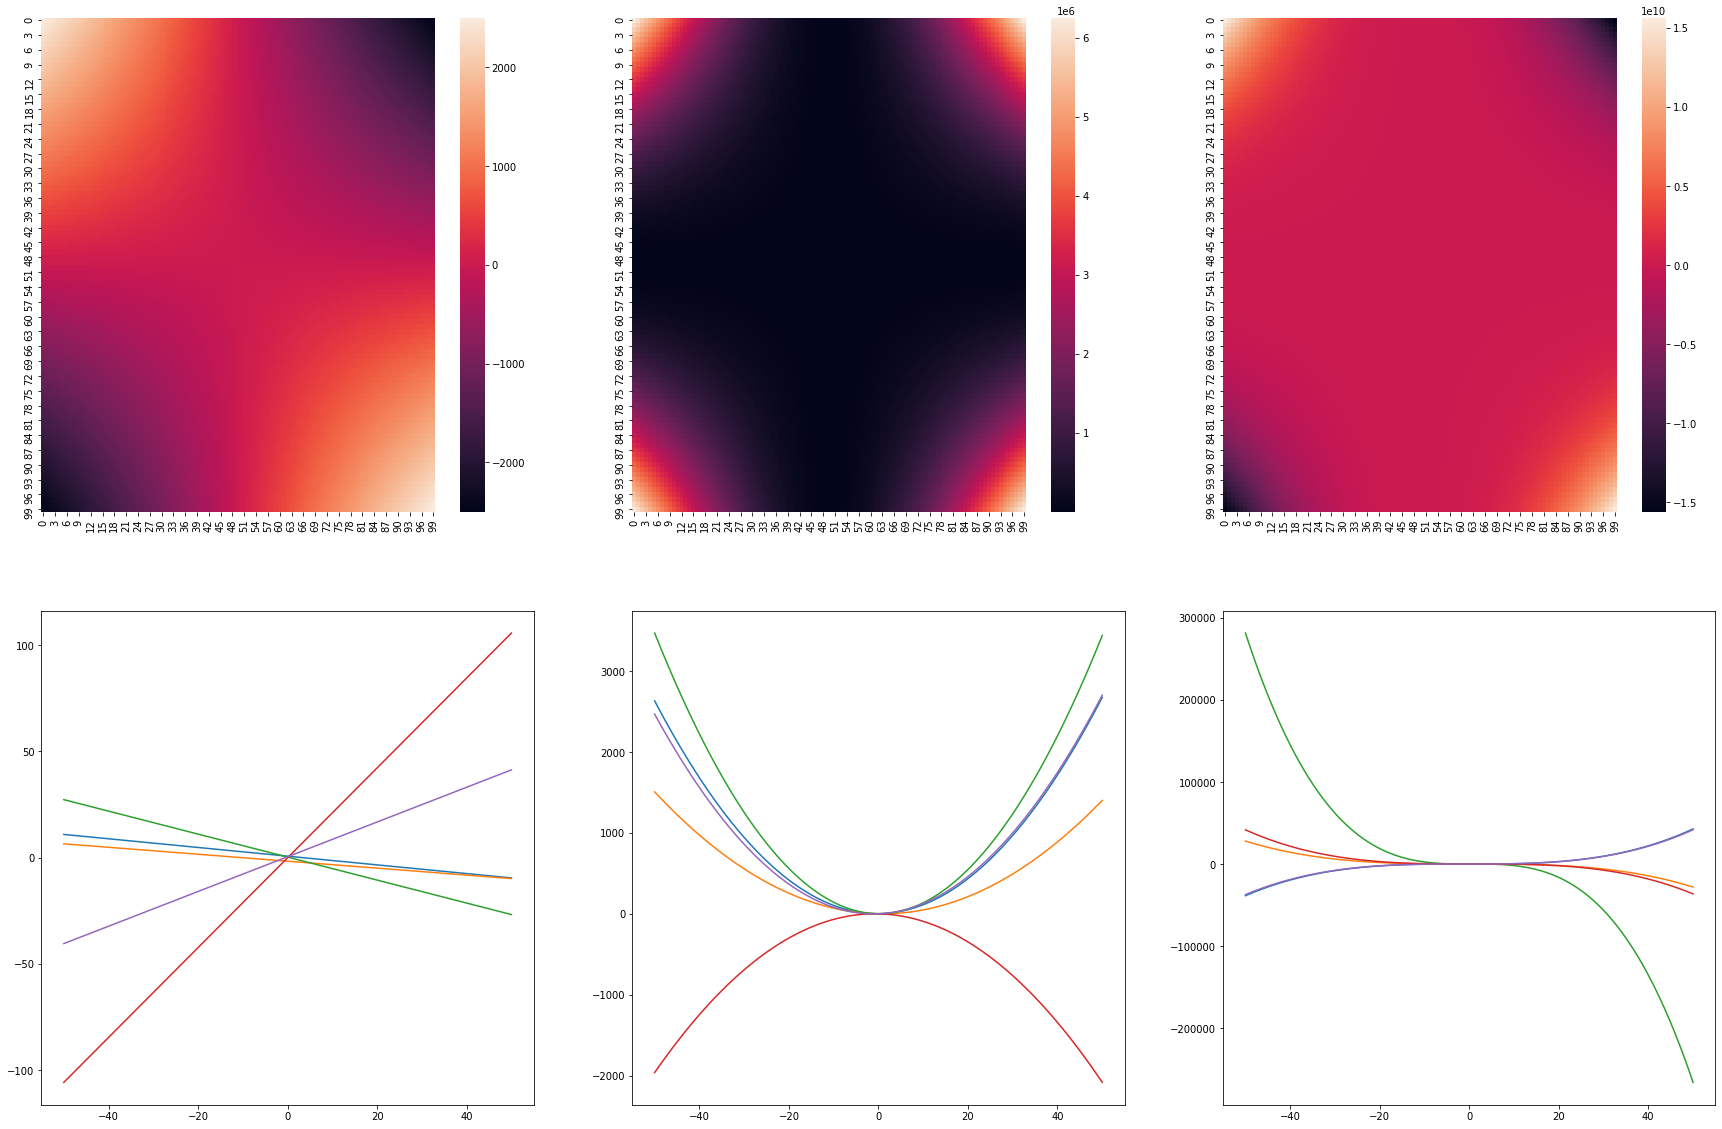

In [34]:
x = np.linspace(-50,50,100)

kernels = [
            DotProduct() ,
            DotProduct()**2,
            DotProduct()**3            
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=5)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


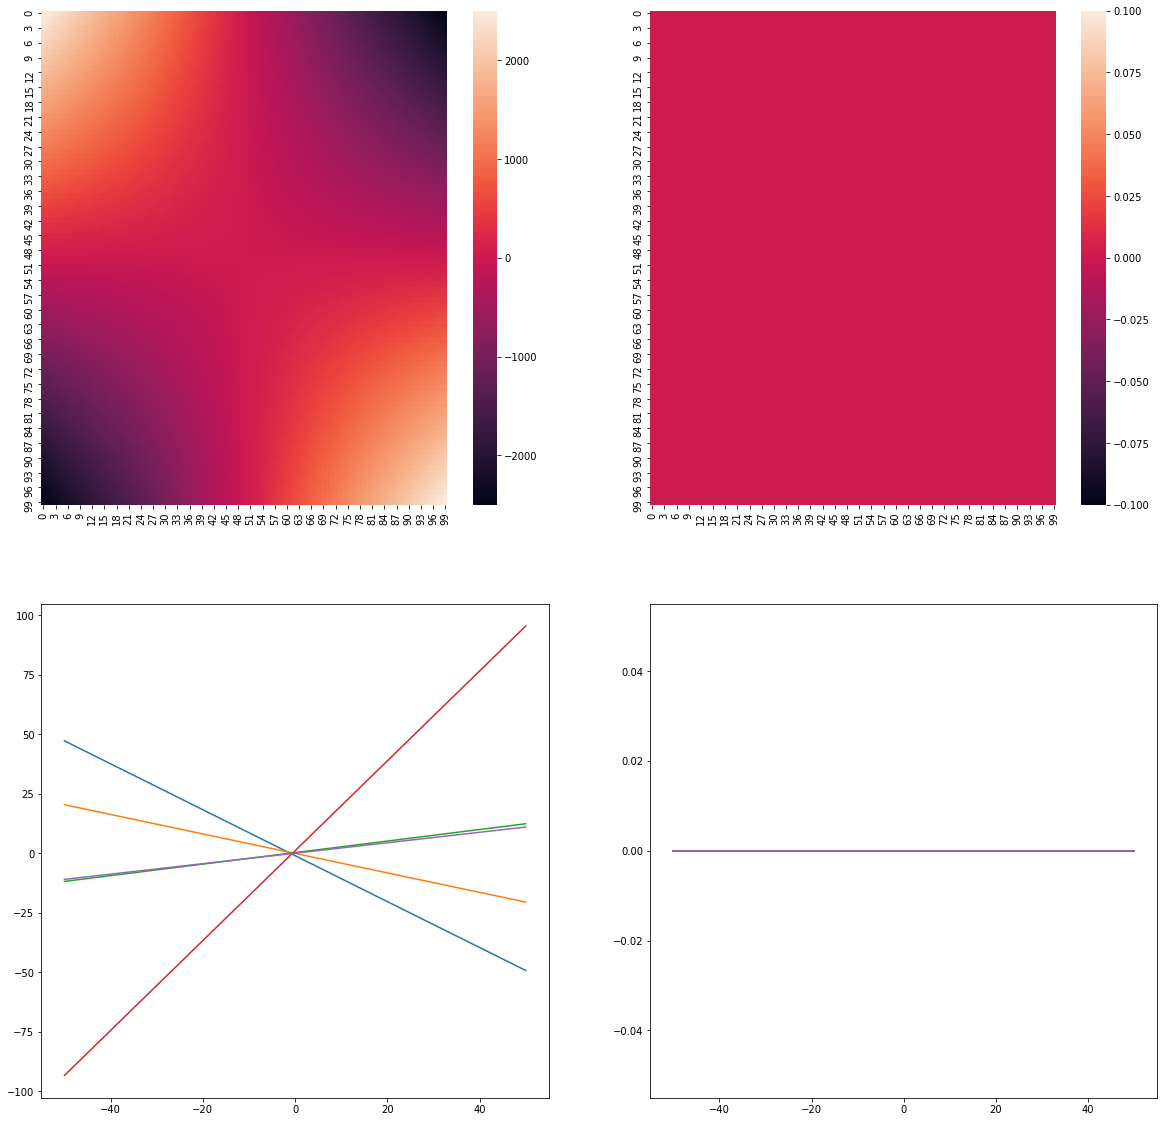

In [35]:
x = np.linspace(-50,50,100)

kernels = [
            DotProduct() ,
            DotProduct()* WhiteKernel(noise_level=5),
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=5)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


# Sigmoid kernel

In [36]:
def sigmoid(x,loc=0,scale=1,slope=1):
    x = x - loc
    return  scale / (1 +  np.exp(-x * slope))


<AxesSubplot:>

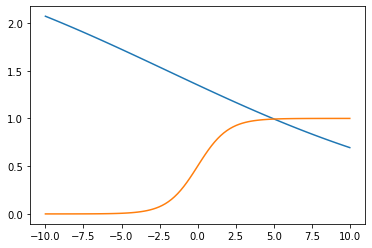

In [37]:
xplot = np.linspace(-10,10,100)
y = sigmoid(xplot,slope=-0.1,scale=3,loc=-2)
sns.lineplot(xplot,y)

y = sigmoid(xplot)
sns.lineplot(xplot,y)


<AxesSubplot:>

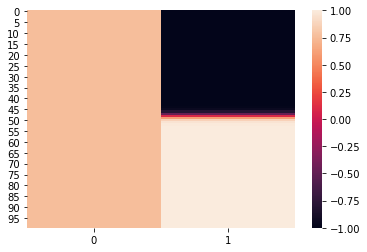

In [38]:
sk= PairwiseKernel(metric='sigmoid')
cov = sk.__call__(xplot.reshape(-1,1),np.array([-0,3]).reshape(-1,1))
sns.heatmap(cov)

In [39]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import sigmoid_kernel

<AxesSubplot:>

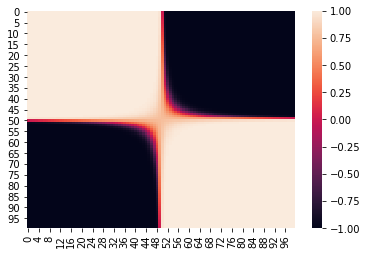

In [40]:
sns.heatmap(sigmoid_kernel(xplot.reshape(-1,1)))

<AxesSubplot:>

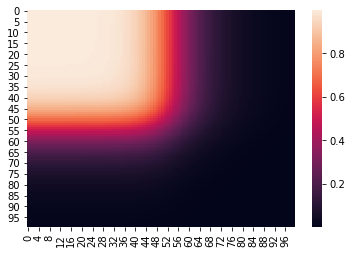

In [41]:
xs = np.sqrt(sigmoid(xplot,loc=0,scale=1,slope=-1))
cov  = DotProduct(0).__call__(xs.reshape(-1,1),xs.reshape(-1,1))
sns.heatmap(cov)

In [42]:
xs.max()

0.9999773008080222

<AxesSubplot:>

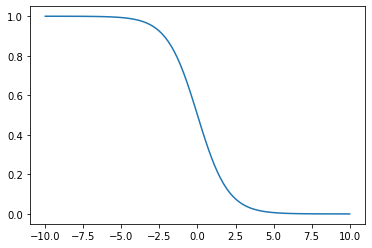

In [43]:
sns.lineplot(xplot,np.diag(cov))


In [44]:
cov.max()

0.9999546021312976

In [45]:
cov.min(),cov.max()

(4.5397868702434395e-05, 0.9999546021312976)

In [46]:
cov2 = xs.reshape(-1,1).dot(xs.reshape(-1,1).T)

In [47]:
cov2 = np.inner(xs.reshape(-1,1),xs.reshape(-1,1))

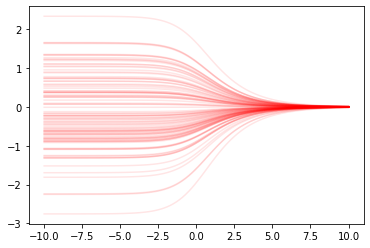

In [48]:
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=100)
for j in range(len(y)):
    sns.lineplot(xplot,y[j,:],color='red',alpha=0.1)

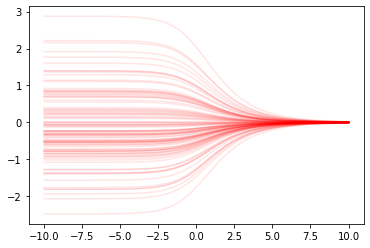

In [49]:
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov2,size=100)
for j in range(len(y)):
    sns.lineplot(xplot,y[j,:],color='red',alpha=0.1)

<AxesSubplot:>

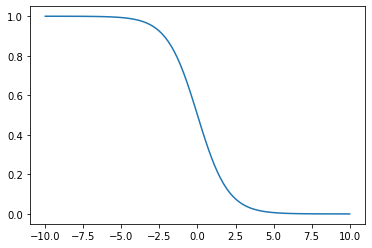

In [51]:
sns.lineplot(xplot,np.diag(cov))

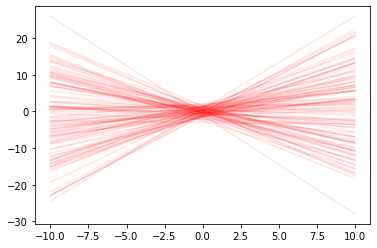

In [52]:
k =  DotProduct()
cov = k.__call__(xplot.reshape(-1,1),xplot.reshape(-1,1))
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=100)
for j in range(len(y)):
    sns.lineplot(xplot,y[j,:],color='red',alpha=0.1)

In [53]:
from sklearn.gaussian_process.kernels import _approx_fprime

In [54]:
_approx_fprime()

TypeError: _approx_fprime() missing 3 required positional arguments: 'xk', 'f', and 'epsilon'

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP

In [ ]:
y = xplot * 3 + np.random.normal(0,1,size=len(xplot))
sns.scatterplot(xplot,y,alpha=0.3)

gp = GP(kernel=DotProduct2(100)).fit(xplot.reshape(-1,1),y)
pred = gp.predict(xplot.reshape(-1,1))
sns.lineplot(xplot,pred,color='red')

In [ ]:
gp.kernel_.theta

In [ ]:
x = np.linspace(-10,10,100)

kernels = [Sigmoid(), Sigmoid() + DotProduct()]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])

In [ ]:
xplot = np.linspace(0,10,100)
k1 = DotProduct(0)
cov = k1.__call__(xplot.reshape(-1,1))

In [ ]:
cov